# CRPS plots
28th December 2024

In [1]:
import glob
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.io import shapereader
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from shapely.geometry import LinearRing
import matplotlib.patheffects as pe

import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

import sys
sys.path.append('/Users/kenzatazi/Documents/CDT/Code')  # noqa
from load import data_dir

from bcm4rcm.utils.areal_plots import regional_rectangle

In [7]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [47]:
# Load CRPS data
crps_rcm_df = pd.read_csv('../../data/moe_outputs/rcm_crps_alpha_p95_historical_1981_2005_ref_1951_1980.csv', index_col=0)
crps_rcm_ds = xr.Dataset.from_dataframe(crps_rcm_df.set_index(['month', 'lon', 'lat']))
crps_rcm_ds

<xarray.Dataset>
Dimensions:         (month: 12, lon: 180, lat: 80)
Coordinates:
  * month           (month) float64 1.0 2.0 3.0 4.0 5.0 ... 9.0 10.0 11.0 12.0
  * lon             (lon) float64 60.12 60.38 60.62 60.88 ... 104.4 104.6 104.9
  * lat             (lat) float64 20.12 20.38 20.62 20.88 ... 39.38 39.62 39.88
Data variables: (12/15)
    CNRM_RCA4       (month, lon, lat) float64 nan nan nan ... 0.002406 0.000387
    CNRM_RegCM4     (month, lon, lat) float64 nan nan nan ... 0.2164 0.2391
    CSIRO_RegCM4    (month, lon, lat) float64 nan nan nan ... 0.2875 0.2936
    CanESM2_RegCM4  (month, lon, lat) float64 nan nan nan ... 0.2096 0.1929
    ECEARTH_RCA4    (month, lon, lat) float64 nan nan nan ... 0.005418 0.003515
    GFDL_RCA4       (month, lon, lat) float64 nan nan nan ... 0.001104 0.001868
    ...              ...
    MIROC_RCA4      (month, lon, lat) float64 nan nan nan ... 0.0004151 0.001355
    MPI_RCA4        (month, lon, lat) float64 nan nan nan ... 0.0008224 0.001837
    MPI_REMO2009    (month, lon, lat) float64 nan nan nan ... 0.000998 0.001746
    MPI_RegCM4      (month, lon, lat) float64 nan nan nan ... 0.2609 0.3097
    moe             (month, lon, lat) float64 nan nan nan ... 0.001215 0.001058
    ew              (month, lon, lat) float64 nan nan nan ... 0.03565 0.05348

In [32]:
# Projection and map features
proj = ccrs.PlateCarree()
ocean_50m = cf.NaturalEarthFeature(
        "physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

In [54]:
# Regional rectangles for the HMA subregions
hma1 = regional_rectangle(71, 79, 32, 39)
hma2 = regional_rectangle(76, 93, 27, 32)
hma3 = regional_rectangle(93, 103, 28, 36)
region_dict = {'HMA1': [71.5, 37.5], 'HMA2': [76.5, 30.5], 'HMA3': [93.5, 34.5],}

In [55]:
# HKH region
hkh_region_path = data_dir + "Shapefiles/hkh/outline.shp"
hkh_region_shape = shapereader.Reader(hkh_region_path)
hkh_region_globe = ccrs.Globe(semimajor_axis=6377276.345, inverse_flattening=300.8017)
hkh_region = ccrs.PlateCarree()

## MoE - EW CRPS

Mixture of experts (MoE) minus equally weighted mixture model (EW) continuous ranked probability score (CRPS) plots.

In [51]:
crps_rcm_ds['crps_diff'] = (crps_rcm_ds['moe'] - crps_rcm_ds['ew'])

In [52]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

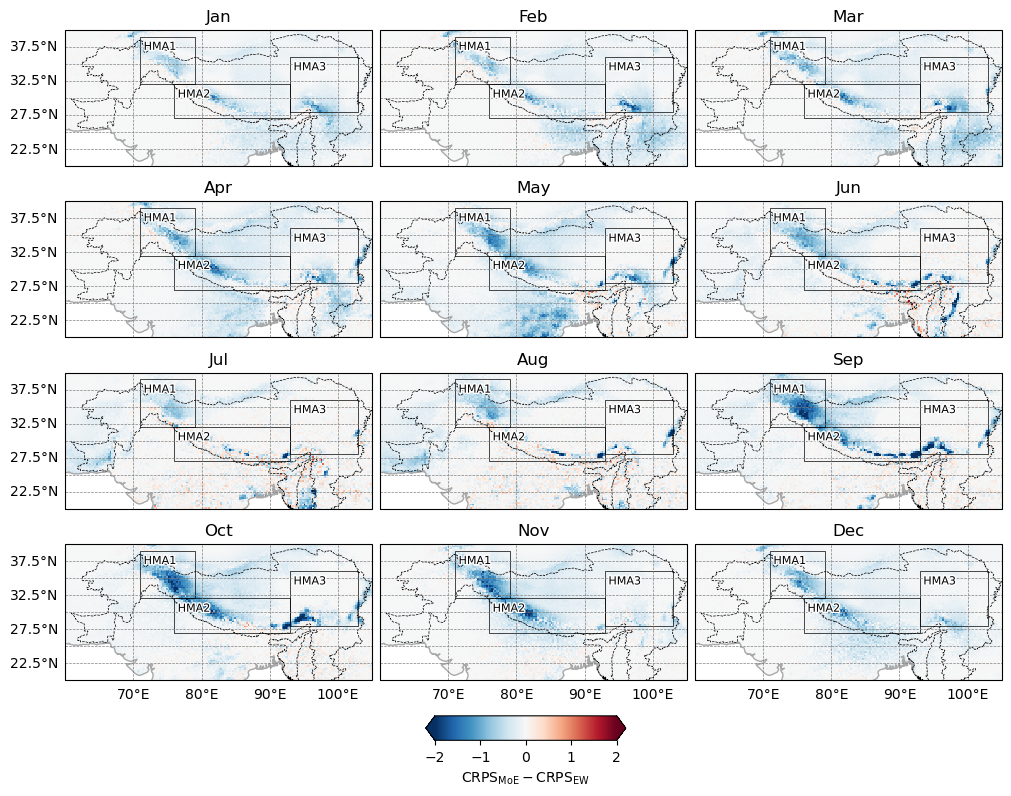

In [56]:
fig, ax = plt.subplots(4, 3, figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()}, layout="constrained")

for i in range(12):
    g = crps_rcm_ds.crps_diff.sel(month=i+1).plot(x='lon', y='lat', ax=ax[i//3, i%3], cmap='RdBu_r', center=0, vmax=2, 
                                                  add_colorbar=False, linewidth=0, zorder=-10)
    ax[i//3, i%3].set_title(months[i])
    gl = ax[i//3, i%3].gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False

    if i % 3 != 0:
       gl.left_labels = False

    if i // 3 != 3:
        gl.bottom_labels = False
    ax[i//3, i%3].add_feature(ocean_50m, zorder=-9)
    ax[i//3, i%3].add_geometries([hma1, hma2, hma3], proj, edgecolor="black",
            facecolor="None", linestyle='-', linewidth=0.5)
    
    for region, coord in region_dict.items():
        ax[i//3, i%3].text(coord[0], coord[1], region, fontsize=8, color='black', ha='left', va='center', zorder=10, 
            path_effects=[pe.withStroke(linewidth=2, foreground="white")])
        
    for rec in hkh_region_shape.records():
        ax[i//3, i%3].add_geometries(
            [rec.geometry],
            hkh_region,
            edgecolor="black",
            facecolor="None",
            linestyle='--',
            linewidth=0.5,
            zorder=-8)


# Rasterize negative zorder
for a in ax.flat:
    a.set_rasterization_zorder(0) 

cax = fig.add_axes([0.42, -0.05, 0.2, 0.035])
fig.colorbar(g, cax=cax, orientation='horizontal', label='$\mathrm{CRPS}_\mathrm{MoE}-\mathrm{CRPS}_\mathrm{EW}$', extend='both')

plt.savefig('moe_ew_crps_alpha_nop95_1981_2005.pdf', dpi=300, bbox_inches='tight')

## Calculate scores over the subregions

In [21]:
hma_crps_diff = crps_rcm_ds.mean(dim=['lon', 'lat'])
print('Average annual CRPS relative difference over HMA:')
print((hma_crps_diff.crps_diff.mean(dim='month')/ hma_crps_diff['ew'].mean(dim='month')).values)

hma1_crps_diff = crps_rcm_ds.sel(lon=slice(71, 79), lat=slice(32, 39)).mean(dim=['lon', 'lat'])
print('Average annual CRPS difference over HMA1:')
print((hma1_crps_diff.crps_diff.mean(dim='month')).values)

hma2_crps_diff = crps_rcm_ds.sel(lon=slice(76, 93), lat=slice(27, 32)).mean(dim=['lon', 'lat'])
print('Average annual CRPS difference over HMA1:')
print((hma2_crps_diff.crps_diff.mean(dim='month')).values)

hma3_crps_diff = crps_rcm_ds.sel(lon=slice(93, 103), lat=slice(28, 36)).mean(dim=['lon', 'lat'])
print('Average annual CRPS difference over HMA3:')
print((hma3_crps_diff.crps_diff.mean(dim='month')).values)

Average annual CRPS relative difference over HMA:
-0.3164086182631857
Average annual CRPS difference over HMA1:
-0.32962965649104564
Average annual CRPS difference over HMA1:
-0.2236017927727232
Average annual CRPS difference over HMA3:
-0.12041914713990208


## MoE - BCM averages

Mixture of experts (MoE) minus equally RCM BCM surrogates, continuous ranked probability score (CRPS) plots.

In [43]:
list(crps_rcm_ds)

['CNRM_RCA4',
 'CNRM_RegCM4',
 'CSIRO_RegCM4',
 'CanESM2_RegCM4',
 'EC-Earth_RCA4',
 'GFDL_RCA4',
 'GFDL_RegCM4',
 'IPSL_RCA4',
 'IPSL_RegCM4',
 'MIROC_RCA4',
 'MPI_RCA4',
 'MPI_REMO2009',
 'MPI_RegCM4',
 'moe',
 'ew',
 'crps_diff']

In [48]:
if "EC-Earth_RCA4" not in crps_rcm_ds:
    # Rename the EC-Earth_RCA4 model to match the other datasets
    crps_rcm_ds = crps_rcm_ds.rename({'ECEARTH_RCA4':'EC-Earth_RCA4'})

In [49]:
# Subtract the MoE from the RCM BCMs and flip the sign
crps_rcm_ds[list(crps_rcm_ds)[:13]]-=crps_rcm_ds['moe']
crps_rcm_ds[list(crps_rcm_ds)[:13]]*=-1
crps_rcm_mean_ds = crps_rcm_ds.mean(dim='month')

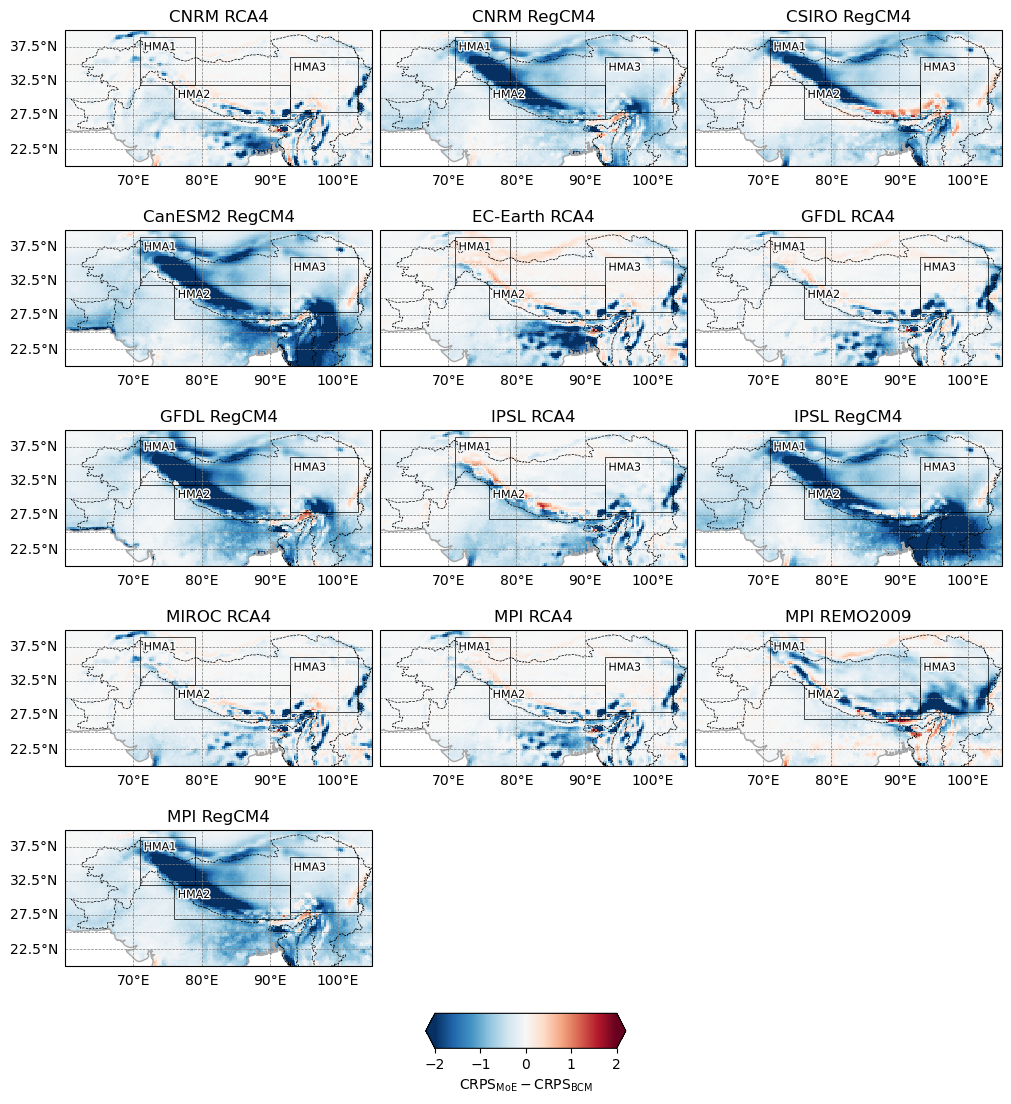

In [57]:
fig, ax = plt.subplots(5, 3, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()}, layout="constrained")

for i in range(13):
    name = list(crps_rcm_ds)[i]
    g = crps_rcm_mean_ds[name].plot(x='lon', y='lat', ax=ax[i//3, i%3], cmap='RdBu_r', center=0, vmax=2, add_colorbar=False, linewidth=0, zorder=-10)
    ax[i//3, i%3].set_title(name.replace('_', ' '))
    gl = ax[i//3, i%3].gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False
    if i % 3 != 0:
       gl.left_labels = False
    
    ax[i//3, i%3].add_feature(ocean_50m, zorder=-9)
    ax[i//3, i%3].add_geometries([hma1, hma2, hma3], proj, edgecolor="black",
            facecolor="None", linestyle='-', linewidth=0.5)
    for region, coord in region_dict.items():
        ax[i//3, i%3].text(coord[0], coord[1], region, fontsize=8, color='black', ha='left', va='center', zorder=10, 
            path_effects=[pe.withStroke(linewidth=2, foreground="white")])
    for rec in hkh_region_shape.records():
        ax[i//3, i%3].add_geometries(
            [rec.geometry],
            hkh_region,
            edgecolor="black",
            facecolor="None",
            linestyle='--',
            linewidth=0.5,
            zorder=-8)

# Rasterize negative zorder
for a in ax.flat:
    a.set_rasterization_zorder(0) 

cax = fig.add_axes([0.42, -0.05, 0.2, 0.035])
fig.colorbar(g, cax=cax, orientation='horizontal', label='$\mathrm{CRPS}_\mathrm{MoE}-\mathrm{CRPS}_\mathrm{BCM}$', extend='both')

fig.delaxes(ax[4, 2])
fig.delaxes(ax[4, 1])

plt.savefig('moe_rcm_crps_alpha_nop95_1981_2005.pdf', dpi=300, bbox_inches='tight')

## CRPS scorecard

In [ ]:
RCMs = list(crps_rcm_df.columns[3:-2])
RCMs.append('ew')

RCMs_labels = [element.replace('_',' ').replace('ew','EW') for element in RCMs]
months_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

n_rcms = len(RCMs)
n_months = 12

# Build up the scorecard array: shape (n_rcms, n_months)
scorecard = np.zeros((n_rcms, n_months))

for i, RCM in enumerate(RCMs):
    for month in range(1, n_months+1):

        # Compute the difference
        data = crps_rcm_ds['moe'].sel(month=month) - crps_rcm_ds[RCM].sel(month=month)
        
        # Storing it in the 2D array
        scorecard[i, month-1] = data.mean().values

# Plot with seaborn's heatmap
fig, ax = plt.subplots(figsize=(10, 6))

# 2-slope norm with the center at 0:
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

g = sns.heatmap(
    scorecard,
    cmap="RdBu_r",
    center=0,
    vmin=-1, vmax=1,
    xticklabels=months_labels,
    yticklabels=RCMs_labels,
    annot=True,
    fmt=".2f",
    # configure the colorbar
    cbar_kws={"extend": "both", "label": "MoE CRPS - BCM CRPS"}
)

plt.savefig('crps_moe_vs_bcms.pdf', dpi=300, bbox_inches='tight')